In [1]:
! pip3 -q install optax equinox

     |████████████████████████████████| 145 kB 32.8 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 85 kB 4.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.2 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [2]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 47 (delta 17), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (47/47), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [3]:
from misc import utils, Chebyshev

from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import Explicit_Euler as Explicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_cJ
from architectures import consistent_matrix
from architectures.SDC_RNN import make_residual_step, compute_residual_loss, make_supervised_step, compute_supervised_loss

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import pickle

from jax import jit, vmap, grad, config, random
from functools import partial
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

# Consistent Matrix model

Consistent matrix model CM($M$, $K$):

  1. $v = \text{Implicit Euler}\left[F, u_0, t_0, t_1\right]$ $-$ generate initial guess using classical integrator
  2. $h = \text{NN}_{\text{init}}\left[v\right]$ $-$ initialise hidden state
  3. for $i=1,\dots,M$

    $\widetilde{v} = \text{SDC}(v)$

    $y = \text{NN}_{\text{encoder}}[\widetilde{v}]$

    $h = \text{GRU}(y, h)$ $-$ multilayer GRU

    $A = \text{NN}_{\text{decoder}}[h]$

    $v = \sum_{i} A_{i} v_{-i} + (I - \sum_{i} A_{i}) \widetilde{v}$

# Training with residual

## Prothero–Robinson (very stiff scalar linear ODE)

In [5]:
delta = 1000
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
T = [t0, t1]
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

corrector = lambda v, delta, F, t0, t1: Implicit_Euler_c.corrector_J(v, delta, F, inv_dF, t0, t1, 1)
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

N_equations = len(u0)
N_input = N_equations*N_points
N_hidden = 100
N_cells = 4
N_hidden_layer = 50

init_shapes = [N_input, ] + [N_hidden_layer] * N_cells + [N_hidden, ]
encoder_shapes = init_shapes
decoder_shapes = encoder_shapes[::-1]
decoder_shapes[-1] = 1*(N_equations*N_points)**2
rnn_shapes = [N_hidden, ] * N_cells
key = random.PRNGKey(11)

NN = consistent_matrix.Consistent_Matrix_Model(init_shapes, encoder_shapes, decoder_shapes, rnn_shapes, N_cells, key, F, corrector, T)

In [6]:
# performance of NN before training

H = NN(values, 20)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

# SDC and AA

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 3, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0, ord=jnp.inf)

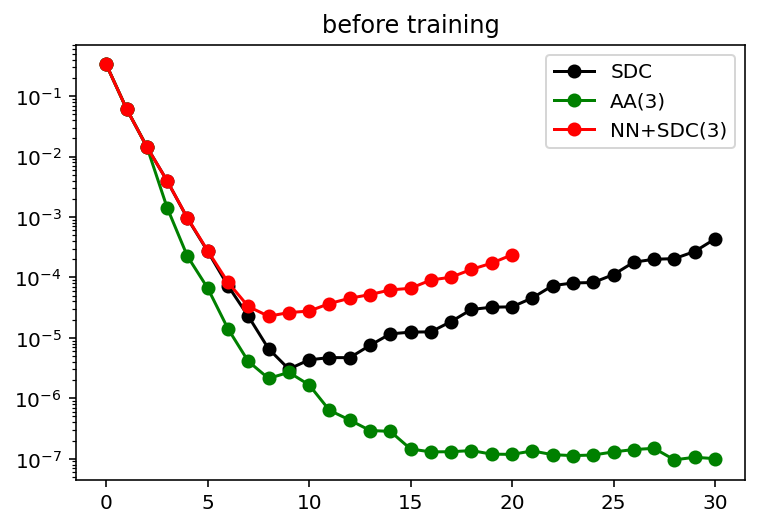

In [7]:
plt.title("before training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC(3)")
plt.legend();

In [8]:
learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 4000, 0.5)
optim = optax.adam(sc)
opt_state = optim.init(eqx.filter(NN, eqx.is_array))

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
values = jnp.expand_dims(values, 0)

In [9]:
make_residual_step(NN, values, F, [t0, t1], 3, opt_state, optim);

In [10]:
%timeit make_residual_step(NN, values, F, [t0, t1], 3, opt_state, optim);

11.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
11 * 40000 * 1e-3 / 60

7.333333333333333

In [12]:
T = [t0, t1]
M = 3

loss = compute_residual_loss(NN, values, F, T, M)
history = [loss.item(), ]

for i in range(40000):
    loss, NN, opt_state = make_residual_step(NN, values, F, T, M, opt_state, optim)
    history.append(loss.item())

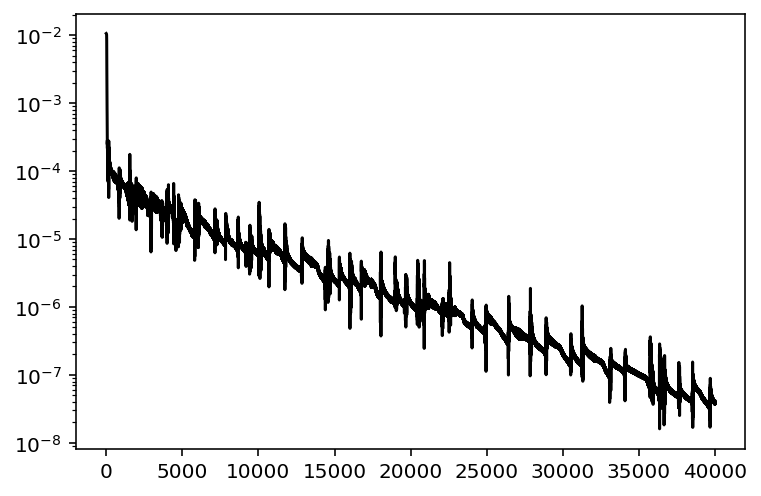

In [13]:
plt.yscale("log")
plt.plot(history, color="black");

In [14]:
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

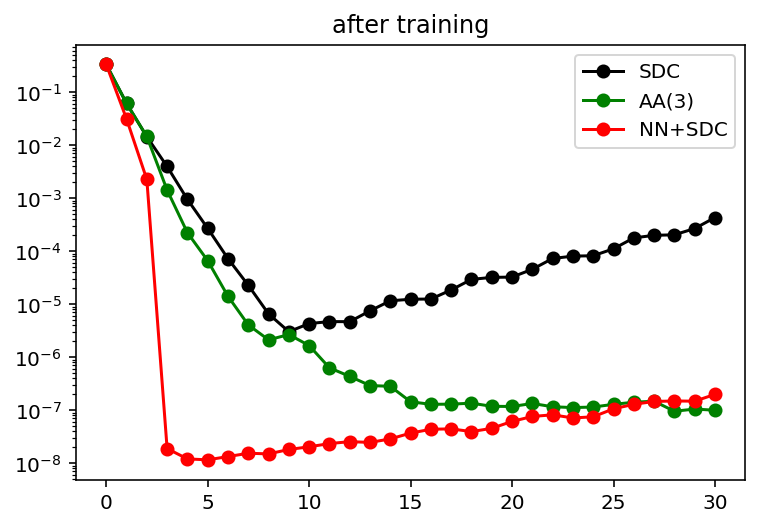

In [15]:
plt.title("after training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC")
plt.legend();

## Van der Pol (mildly stiff vector nonlinear ODE)

In [16]:
epsilon = 0.1
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
T = [t0, t1]
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 3.0])

def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

corrector = lambda v, delta, F, t0, t1: Implicit_Euler_c.corrector_J(v, delta, F, inv_dF, t0, t1, 1)
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

N_equations = len(u0)
N_input = N_equations*N_points
N_hidden = 100
N_cells = 4
N_hidden_layer = 50

init_shapes = [N_input, ] + [N_hidden_layer] * N_cells + [N_hidden, ]
encoder_shapes = init_shapes
decoder_shapes = encoder_shapes[::-1]
decoder_shapes[-1] = 2*(N_equations*N_points)**2
rnn_shapes = [N_hidden, ] * N_cells
key = random.PRNGKey(11)

NN = consistent_matrix.Consistent_Matrix_Model(init_shapes, encoder_shapes, decoder_shapes, rnn_shapes, N_cells, key, F, corrector, T)

In [17]:
# performance of NN before training

H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

# SDC and AA

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 3, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0, ord=jnp.inf)

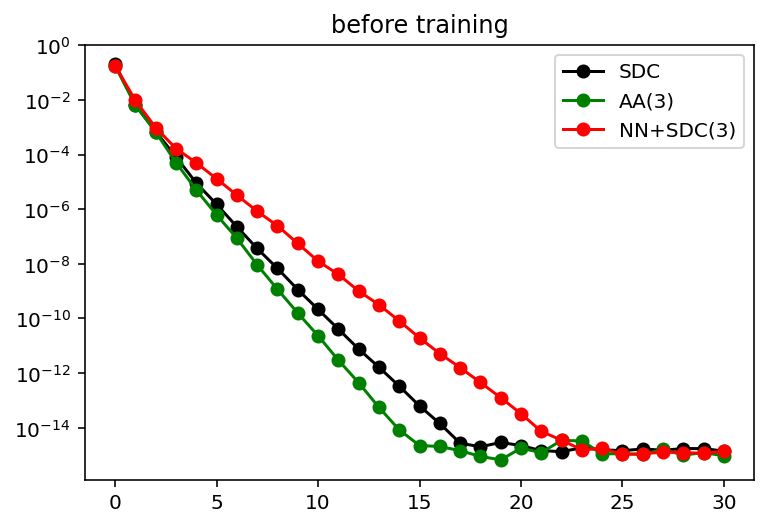

In [18]:
plt.title("before training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC(3)")
plt.legend();

In [19]:
learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 4000, 0.5)
optim = optax.adam(sc)
opt_state = optim.init(eqx.filter(NN, eqx.is_array))

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
values = jnp.expand_dims(values, 0)

In [20]:
make_residual_step(NN, values, F, [t0, t1], 3, opt_state, optim);

In [21]:
%timeit make_residual_step(NN, values, F, [t0, t1], 3, opt_state, optim);

22.9 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
27 * 30000 * 1e-3 / 60

13.5

In [23]:
T = [t0, t1]
M = 3

loss = compute_residual_loss(NN, values, F, T, M)
history = [loss.item(), ]

for i in range(30000):
    loss, NN, opt_state = make_residual_step(NN, values, F, T, M, opt_state, optim)
    history.append(loss.item())

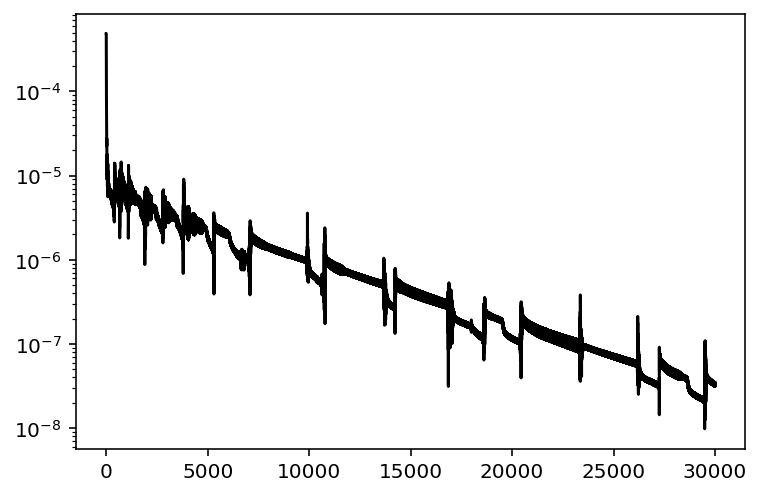

In [24]:
plt.yscale("log")
plt.plot(history, color="black");

In [25]:
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

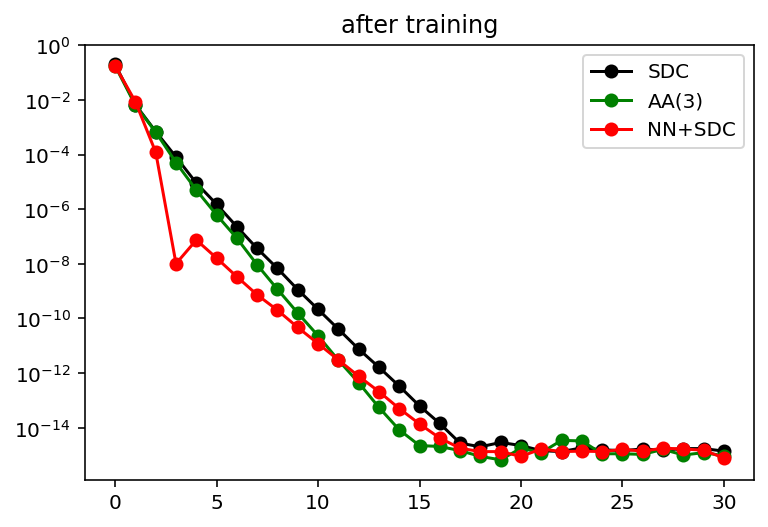

In [26]:
plt.title("after training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC")
plt.legend();

# Supervised training

## Prothero–Robinson (very stiff scalar linear ODE)

In [27]:
delta = 1000
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
T = [t0, t1]
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

corrector = lambda v, delta, F, t0, t1: Implicit_Euler_c.corrector_J(v, delta, F, inv_dF, t0, t1, 1)
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

N_equations = len(u0)
N_input = N_equations*N_points
N_hidden = 100
N_cells = 4
N_hidden_layer = 50

init_shapes = [N_input, ] + [N_hidden_layer] * N_cells + [N_hidden, ]
encoder_shapes = init_shapes
decoder_shapes = encoder_shapes[::-1]
decoder_shapes[-1] = 1*(N_equations*N_points)**2
rnn_shapes = [N_hidden, ] * N_cells
key = random.PRNGKey(11)

NN = consistent_matrix.Consistent_Matrix_Model(init_shapes, encoder_shapes, decoder_shapes, rnn_shapes, N_cells, key, F, corrector, T)

In [28]:
# performance of NN before training

H = NN(values, 20)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

# SDC and AA

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 3, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0, ord=jnp.inf)

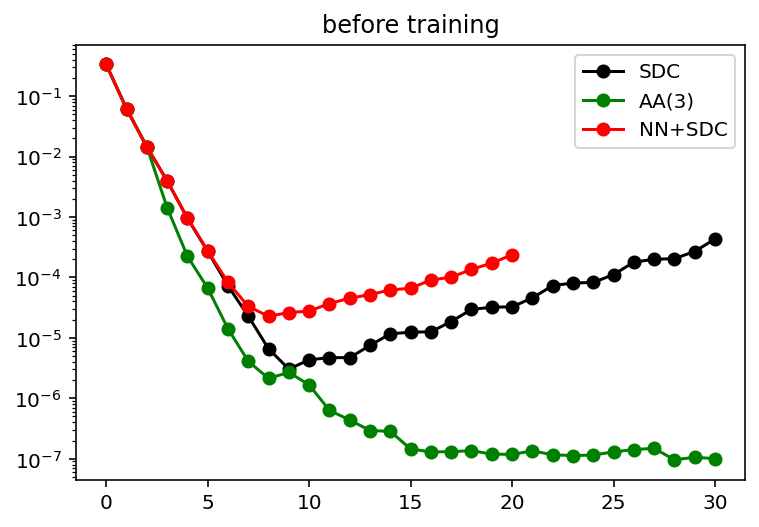

In [29]:
plt.title("before training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC")
plt.legend();

In [30]:
learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 4000, 0.5)
optim = optax.adam(sc)
opt_state = optim.init(eqx.filter(NN, eqx.is_array))

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
values = jnp.expand_dims(values, 0)
target = jnp.expand_dims(exact_solution, 0)

In [31]:
make_supervised_step(NN, values, target, F, [t0, t1], 3, opt_state, optim);

In [32]:
%timeit make_supervised_step(NN, values, target, F, [t0, t1], 3, opt_state, optim);

10.3 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
11 * 40000 * 1e-3 / 60

7.333333333333333

In [34]:
T = [t0, t1]
M = 3

loss = compute_supervised_loss(NN, values, target, F, T, M)
history = [loss.item(), ]

for i in range(40000):
    loss, NN, opt_state = make_supervised_step(NN, values, target, F, T, M, opt_state, optim)
    history.append(loss.item())

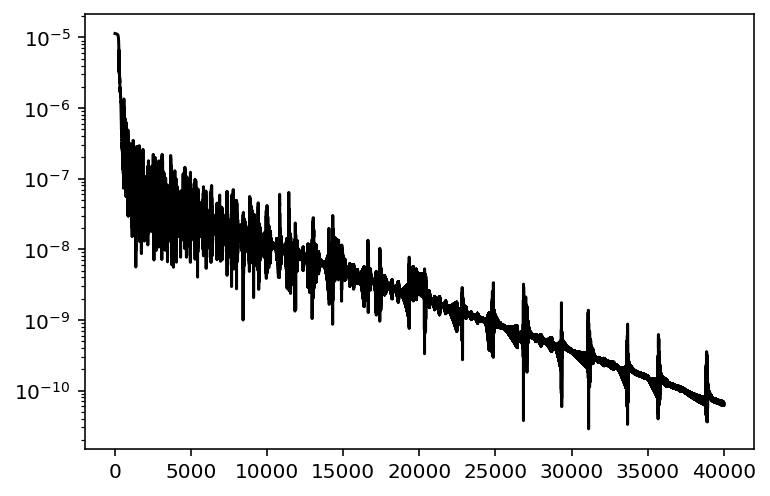

In [35]:
plt.yscale("log")
plt.plot(history, color="black");

In [36]:
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

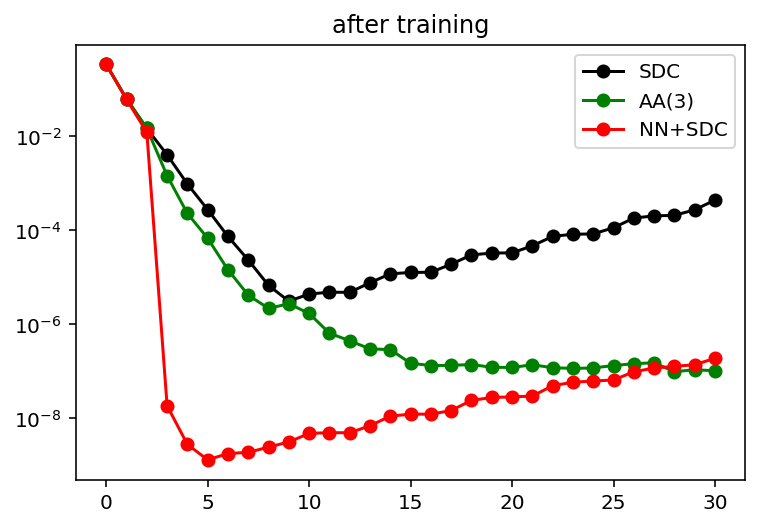

In [37]:
plt.title("after training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC")
plt.legend();

## Van der Pol (mildly stiff vector nonlinear ODE)

In [38]:
epsilon = 0.1
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
T = [t0, t1]
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 3.0])

def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

corrector = lambda v, delta, F, t0, t1: Implicit_Euler_c.corrector_J(v, delta, F, inv_dF, t0, t1, 1)
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

N_equations = len(u0)
N_input = N_equations*N_points
N_hidden = 100
N_cells = 4
N_hidden_layer = 50

init_shapes = [N_input, ] + [N_hidden_layer] * N_cells + [N_hidden, ]
encoder_shapes = init_shapes
decoder_shapes = encoder_shapes[::-1]
decoder_shapes[-1] = 2*(N_equations*N_points)**2
rnn_shapes = [N_hidden, ] * N_cells
key = random.PRNGKey(11)

NN = consistent_matrix.Consistent_Matrix_Model(init_shapes, encoder_shapes, decoder_shapes, rnn_shapes, N_cells, key, F, corrector, T)

In [39]:
# performance of NN before training

H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

# SDC and AA

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

exact = values

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 3, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0, ord=jnp.inf)

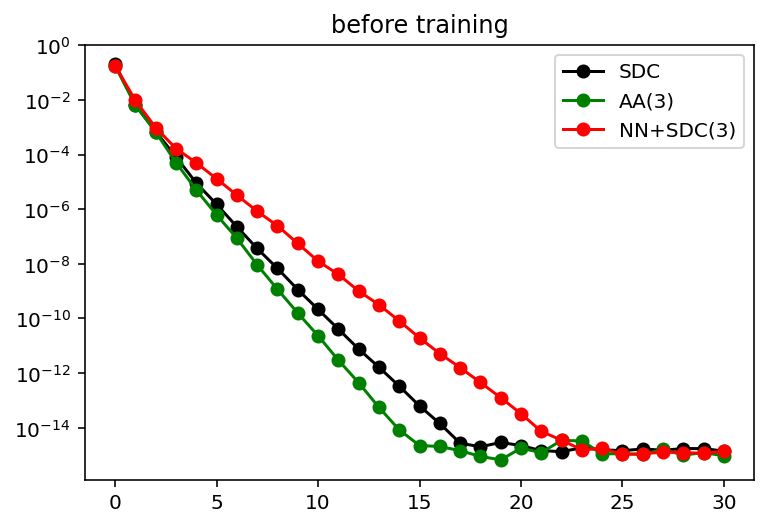

In [40]:
plt.title("before training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC(3)")
plt.legend();

In [41]:
learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 4000, 0.5)
optim = optax.adam(sc)
opt_state = optim.init(eqx.filter(NN, eqx.is_array))

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
values = jnp.expand_dims(values, 0)
target = jnp.expand_dims(exact, 0)

In [42]:
make_supervised_step(NN, values, target, F, [t0, t1], 3, opt_state, optim);

In [43]:
%timeit make_supervised_step(NN, values, target, F, [t0, t1], 3, opt_state, optim);

24 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
26.2 * 20000 * 1e-3 / 60

8.733333333333333

In [45]:
T = [t0, t1]
M = 3

loss = compute_supervised_loss(NN, values, target, F, T, M)
history = [loss.item(), ]

for i in range(20000):
    loss, NN, opt_state = make_supervised_step(NN, values, target, F, T, M, opt_state, optim)
    history.append(loss.item())

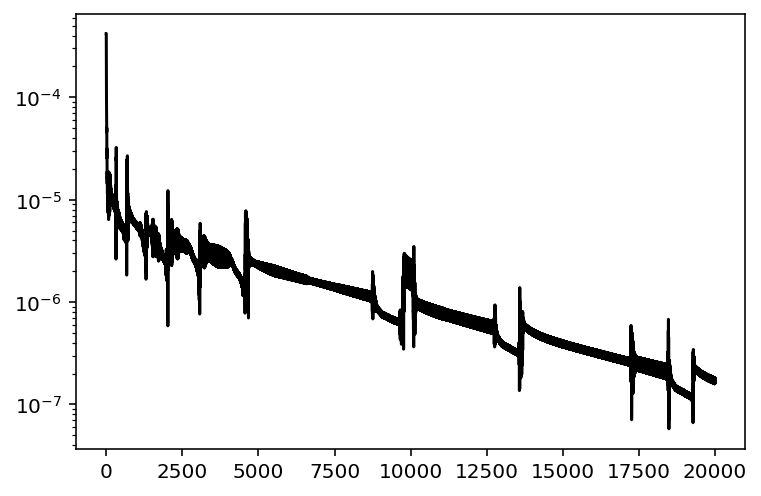

In [46]:
plt.yscale("log")
plt.plot(history, color="black");

In [47]:
values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
H = NN(values, 30)[0]
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(H, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0, ord=jnp.inf)

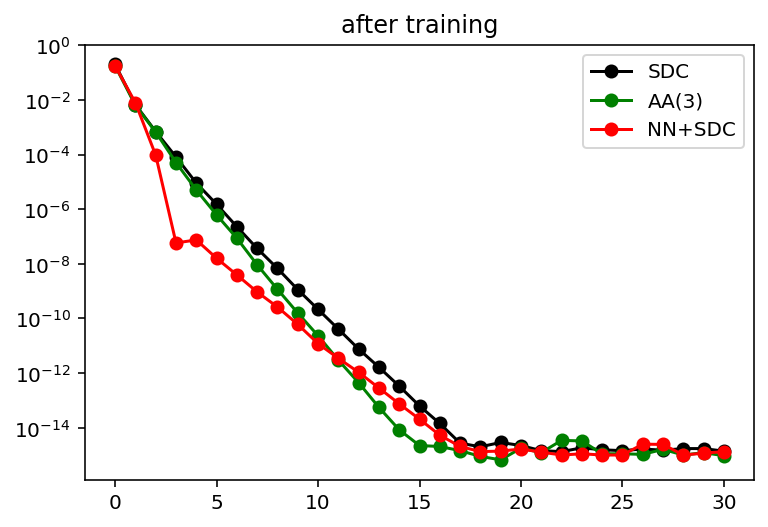

In [48]:
plt.title("after training")
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(3)")
plt.plot(R1, "o-", color="red", label="NN+SDC")
plt.legend();